In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
config = {
    'domain': 'protein',
    'postgres': False,
    'debug': False,
    'babbler_candidate_split': 1,
    'babbler_label_split': 1,
    'supervision': 'generative',
    'disc_model_class': 'logreg',    
}

In [3]:
# Get DB connection string and add to globals
# NOTE: $SNORKELDB must be set before any snorkel imports
import os

default_db_name = 'babble_' + config['domain'] + ('_debug' if config.get('debug', False) else '')
DB_NAME = config.get('db_name', default_db_name)
if 'postgres' in config and config['postgres']:
    DB_TYPE = 'postgres'
else:
    DB_TYPE = 'sqlite'
    DB_NAME += '.db'
DB_ADDR = "localhost:{0}".format(config['db_port']) if 'db_port' in config else ""
os.environ['SNORKELDB'] = '{0}://{1}/{2}'.format(DB_TYPE, DB_ADDR, DB_NAME)
print("$SNORKELDB = {0}".format(os.environ['SNORKELDB']))

$SNORKELDB = sqlite:///babble_protein.db


In [4]:
from snorkel import SnorkelSession
session = SnorkelSession()

# Resolve config conflicts (nb_config > local_config > global_config)
from snorkel.contrib.babble.pipelines import merge_configs, get_local_pipeline
config = merge_configs(config)

if config['debug']:
    print("NOTE: --debug=True: modifying parameters...")
    config['max_docs'] = 100
    config['gen_model_search_space'] = 1
    config['disc_model_search_space'] = 1
    config['gen_params_default']['epochs'] = 25
    config['disc_params_default']['n_epochs'] = 5

from snorkel.models import candidate_subclass
candidate_class = candidate_subclass(config['candidate_name'], config['candidate_entities'])

pipeline = get_local_pipeline(config['domain'])
pipe = pipeline(session, candidate_class, config)

Overwriting domain=None to domain=protein
Overwriting disc_model_class=lstm to disc_model_class=logreg


In [5]:
%time pipe.parse()

Clearing existing...
Running UDF...
[========================================] 100%

Documents: 4735
Sentences: 43386
CPU times: user 1min 8s, sys: 2.09 s, total: 1min 10s
Wall time: 11min 4s


Could not kill CoreNLP server [23544] [Errno 3] No such process


In [6]:
%time pipe.extract()

Clearing existing...
Running UDF...
[========================================] 100%

Candidates [Split 0]: 7011
Clearing existing...
Running UDF...
[========================================] 100%

Candidates [Split 1]: 1168
Clearing existing...
Running UDF...
[========================================] 100%

Candidates [Split 2]: 1203
CPU times: user 45 s, sys: 979 ms, total: 46 s
Wall time: 46.1 s


In [7]:
%time pipe.load_gold()

AnnotatorLabels created: 0
AnnotatorLabels created: 1168
AnnotatorLabels created: 1203
CPU times: user 52.3 s, sys: 765 ms, total: 53.1 s
Wall time: 53.3 s


In [8]:
%time pipe.featurize()

Clearing existing...
Running UDF...
[========================================] 100%

Featurized split 0: (7011,117650) sparse (nnz = 365530)
Clearing existing...
Running UDF...
[========================================] 100%

Featurized split 1: (1168,117650) sparse (nnz = 39454)
Clearing existing...
Running UDF...
[========================================] 100%

Featurized split 2: (1203,117650) sparse (nnz = 40178)
CPU times: user 8min 10s, sys: 5.23 s, total: 8min 15s
Wall time: 8min 34s


In [9]:
%time pipe.collect()

Skipping malformed or header row 23...
Linking candidates...
Building list of target candidate ids...
Collected 29 unique target candidate ids from 56 explanations.
Gathering desired candidates...
Found 29/29 desired candidates
Linking explanations to candidates...
Linked 56/56 explanations
Calling babbler...
Flushing all parses from previous explanation set.
Created grammar with 593 rules
54 explanation(s) out of 56 were parseable.
142 parse(s) generated from 56 explanation(s).
46 parse(s) remain (96 parse(s) removed by DuplicateSemanticsFilter).
23 parse(s) remain (23 parse(s) removed by ConsistencyFilter).
### Applying labeling functions to split 1
[========================================] 100%

### Done in 2.5s.

23 parse(s) remain (0 parse(s) removed by UniformSignatureFilter: (0 None, 0 All)).
21 parse(s) remain (2 parse(s) removed by DuplicateSignatureFilter).
Added 21 parse(s) from 21 explanations to set. (Total # parses = 21)
CPU times: user 9.58 s, sys: 586 ms, total: 10.2 s

In [10]:
pipe.babbler.filtered_analysis()

SUMMARY
123 TOTAL:
2 Unparseable Explanation
96 Duplicate Semantics
23 Inconsistency with Example
0 Uniform Signature
2 Duplicate Signature

[#1]: Unparseable Explanation

Explanation: because word 'cause an accumulation of' is between them

Reason: This explanation couldn't be parsed.


[#2]: Unparseable Explanation

Explanation: because word 'cause an accumulation of' is before the Protein

Reason: This explanation couldn't be parsed.


[#3]: Duplicate Semantics

Parse: return 1 if 'substrate of'.in(text(between([X,Y]))) else 0

Reason: This parse is identical to one produced by the following explanation:
	"because word 'substrate of' is between them "


[#4]: Duplicate Semantics

Parse: return -1 if 'substrate of'.(= text(Y)) else 0

Reason: This parse is identical to one produced by the following explanation:
	"because word 'substrate of' is before the kinase"


[#5]: Duplicate Semantics

Parse: return -1 if 'substrate of'.in(text(greater than 0 word(s) to the left of Y)) else 0

R

In [11]:
%time pipe.label()

Clearing existing...
Running UDF...
[========================================] 100%

Labeled split 0: (7011,21) sparse (nnz = 866)

Clearing existing...
Running UDF...
[========================================] 100%

Labeled split 1: (1168,21) sparse (nnz = 290)

                  j  Coverage  Overlaps  Conflicts  TP  FP  FN  TN  \
Explanation0_0    0  0.006849  0.001712   0.000856   4   4   0   0   
Explanation2_0    1  0.006849  0.000856   0.000856   4   4   0   0   
Explanation4_0    2  0.047945  0.035959   0.035103  19  37   0   0   
Explanation5_1    3  0.044521  0.035959   0.035959   0   0  17  35   
Explanation15_0   4  0.017123  0.000000   0.000000  12   8   0   0   
Explanation17_0   5  0.020548  0.001712   0.001712  14  10   0   0   
Explanation24_1   6  0.000856  0.000856   0.000856   0   0   0   1   
Explanation26_1   7  0.001712  0.000000   0.000000   0   2   0   0   
Explanation32_0   8  0.000856  0.000856   0.000856   0   1   0   0   
Explanation33_1   9  0.041096  0.005

Using L_train: <7011x21 sparse matrix of type '<type 'numpy.int64'>'
	with 866 stored elements in Compressed Sparse Row format>
Using L_gold_train: <7011x1 sparse matrix of type '<type 'numpy.int64'>'
	with 0 stored elements in Compressed Sparse Row format>
Positive Fraction: 0.0%

Using L_dev: <1168x21 sparse matrix of type '<type 'numpy.int64'>'
	with 290 stored elements in Compressed Sparse Row format>
Using L_gold_dev: <1168x1 sparse matrix of type '<type 'numpy.int64'>'
	with 1168 stored elements in Compressed Sparse Row format>
Positive Fraction: 19.2%

Using L_test: <1203x21 sparse matrix of type '<type 'numpy.int64'>'
	with 326 stored elements in Compressed Sparse Row format>
Using L_gold_test: <1203x1 sparse matrix of type '<type 'numpy.int64'>'
	with 1203 stored elements in Compressed Sparse Row format>
Positive Fraction: 19.0%

[1] Testing LF_acc_prior_weight_default = 1.00e+00, step_size = 1.00e-02, reg_param = 1.00e-01, decay = 9.50e-01
Inferred cardinality: 2
[GenerativeM

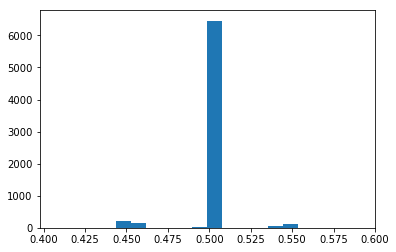

Saved 7011 marginals
CPU times: user 4min, sys: 1.56 s, total: 4min 2s
Wall time: 4min 2s


In [12]:
%time pipe.supervise()

(7011,)


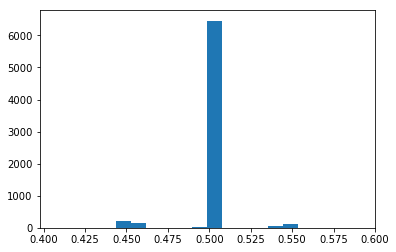

### [7.1] Begin training discriminative model
[1] Testing dim = 64, dropout = 2.50e-01, rebalance = 0.00e+00, lr = 1.00e-03
[SparseLogisticRegression] Training model
[SparseLogisticRegression] n_train=684  #epochs=20  batch size=128
[SparseLogisticRegression] Epoch 0 (0.05s)	Average loss=0.752066	Dev F1=25.65
[SparseLogisticRegression] Epoch 1 (0.13s)	Average loss=0.734316	Dev F1=25.29
[SparseLogisticRegression] Epoch 2 (0.20s)	Average loss=0.722492	Dev F1=25.45
[SparseLogisticRegression] Epoch 3 (0.28s)	Average loss=0.713663	Dev F1=25.61
[SparseLogisticRegression] Epoch 4 (0.36s)	Average loss=0.707419	Dev F1=25.69
[SparseLogisticRegression] Epoch 5 (0.43s)	Average loss=0.703589	Dev F1=25.75
[SparseLogisticRegression] Epoch 6 (0.51s)	Average loss=0.700732	Dev F1=25.51
[SparseLogisticRegression] Epoch 7 (0.59s)	Average loss=0.698286	Dev F1=24.84
[SparseLogisticRegression] Epoch 8 (0.66s)	Average loss=0.696790	Dev F1=24.81
[SparseLogisticRegression] Epoch 9 (0.74s)	Average loss=0.695366	

In [13]:
%time pipe.classify()